# Normal breast epithelia comprise three major populations plus transient intermediates

This notebook attempts to reproduce the analysis done to arrive at the source papers first result, normal breast tissue contains three major types of cells: basal, luminal progenitor, and mature luminal.

This analysis was performed on the single-cell RNA sequencing data for 11 subjects, corresponding to the following identifiers:
|"Sample" identifier|File identifier|
|---|---|
|N-1105-epi|`GSM4909260_N-N1105-Epi`|
|N-0280-epi|`GSM4909255_N-N280-Epi`|
|N-0230.16-epi|`GSM4909264_N-N1B-Epi`|
|N-0408-epi|`GSM4909259_N-NE-Epi`|
|N-1469-epi|`GSM4909258_N-NF-Epi`|
|N-0123-epi|`GSM4909267_N-MH0023-Epi`|
|N-0064-epi|`GSM4909313_N-MH0064-Epi`|
|N-0093-epi|`GSM4909256_N-PM0095-Epi`|
|N-0342-epi|`GSM4909269_N-PM0342-Epi`|
|N-0372-epi|`GSM4909275_N-PM0372-Epi`|
|N-0275-epi|`GSM4909273_N-MH275-Epi`|

This table was arrived at through:
* Figure 1c in the source article lists the "Sample" (quotes to emphasize in the context of the article, a sample is analogous to a human subject) identifiers used.
* Supplementary table 1 of the source article maps identifiers to file identifiers.

## 0. Initializations

In [1]:
# -- imports --
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc

from signals_in_the_noise.utilities.storage import get_resources_path
from signals_in_the_noise.preprocessing.data_gse161529 import GSE161529

In [2]:
# -- datasets --
filenames = [
    "GSM4909255_N-N280-Epi.h5ad",
    "GSM4909256_N-PM0095-Epi.h5ad",
    "GSM4909258_N-NF-Epi.h5ad",
    "GSM4909259_N-NE-Epi.h5ad",
    "GSM4909260_N-N1105-Epi.h5ad",
    "GSM4909262_N-MH0064-Epi.h5ad",
    "GSM4909264_N-N1B-Epi.h5ad",
    "GSM4909267_N-MH0023-Epi.h5ad",
    "GSM4909269_N-PM0342-Epi.h5ad",
    "GSM4909273_N-MH275-Epi.h5ad",
    "GSM4909275_N-PM0372-Epi.h5ad",
]
gse = GSE161529()

2025-07-11 16:05:55,636 [INFO] signals_in_the_noise.utilities.tenx_genomics: Reading C:\Users\silly\GitHub\signals-in-the-noise\data\GSE161529_adata_cache\GSM4909253_N-PM0092-Total.h5ad as AnnData object.
2025-07-11 16:05:55,940 [INFO] signals_in_the_noise.utilities.tenx_genomics: Reading C:\Users\silly\GitHub\signals-in-the-noise\data\GSE161529_adata_cache\GSM4909254_N-PM0019-Total.h5ad as AnnData object.
2025-07-11 16:05:56,305 [INFO] signals_in_the_noise.utilities.tenx_genomics: Reading C:\Users\silly\GitHub\signals-in-the-noise\data\GSE161529_adata_cache\GSM4909255_N-N280-Epi.h5ad as AnnData object.
2025-07-11 16:05:56,533 [INFO] signals_in_the_noise.utilities.tenx_genomics: Reading C:\Users\silly\GitHub\signals-in-the-noise\data\GSE161529_adata_cache\GSM4909256_N-PM0095-Epi.h5ad as AnnData object.
2025-07-11 16:05:57,001 [INFO] signals_in_the_noise.utilities.tenx_genomics: Reading C:\Users\silly\GitHub\signals-in-the-noise\data\GSE161529_adata_cache\GSM4909257_N-PM0095-Total.h5ad 

In [3]:
# -- utility methods --
def kde_gene_signature_score(adata, signature_name):
    score_name = f'score_{signature_name}'
    x_label = f'{signature_name.capitalize()} score'
    title = f'Distribution of {signature_name} gene signature score'
    sns.histplot(adata.obs[score_name], kde=True, bins=50)
    plt.axvline(x=adata.obs[score_name].mean(), color='red', linestyle='--', label='Mean')
    plt.xlabel(x_label)
    plt.ylabel("Cell count")
    plt.title(title)
    plt.legend()
    plt.show()

## 1. Additional preprocessing
For this finding, the authors leveraged the work of Lim *et al* (2009) [2] for the gene signatures of basal, luminal progenitor, and mature luminal signatures. Using these signatures, the authors were able to classify the sequencing data as either one of these 3 populations or other.

To reproduce their analysis, I use the following supplementary files from Lim *et al* that contain the gene signature to classify the cell data:
|Population|Filename|
|---|---|
|basal|`41591_2009_BFnm2000_MOESM13_ESM.xls`|
|luminal progenitor (lp)|`41591_2009_BFnm2000_MOESM14_ESM.xls`|
|mature luminal (ml)|`41591_2009_BFnm2000_MOESM15_ESM.xls`|

In [4]:
gene_signature_filenames = {
    'basal': '41591_2009_BFnm2000_MOESM13_ESM.xls',
    'lp': '41591_2009_BFnm2000_MOESM14_ESM.xls',
    'ml': '41591_2009_BFnm2000_MOESM15_ESM.xls',
}

### 1.1. Score datasets for gene signature expressions



In [5]:
adata = gse.objects[filenames[0]].copy()

In [6]:
adata.obs['total_counts'].describe()

count     1198.000000
mean      6474.341309
std       5706.500488
min        503.000000
25%       2399.750000
50%       4753.000000
75%       8662.500000
max      39818.000000
Name: total_counts, dtype: float64

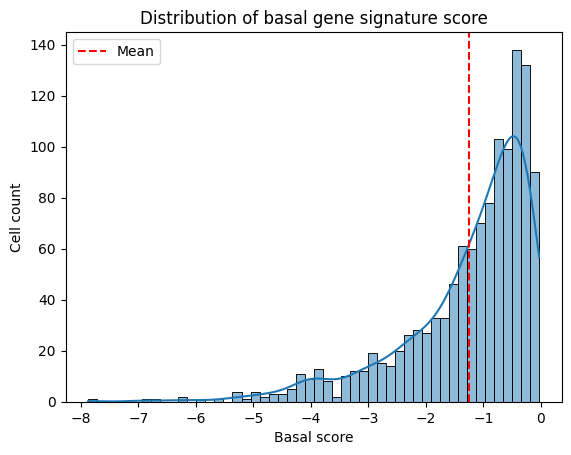

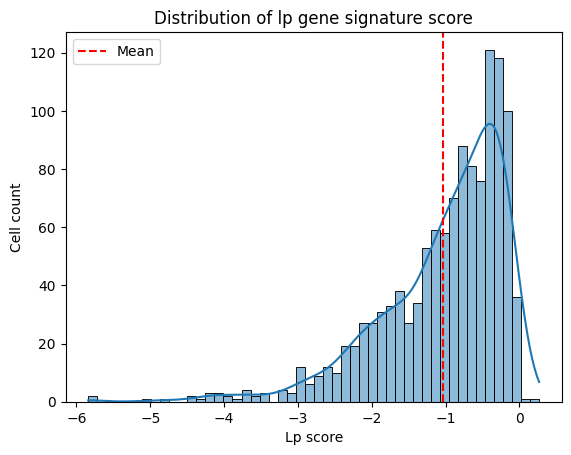

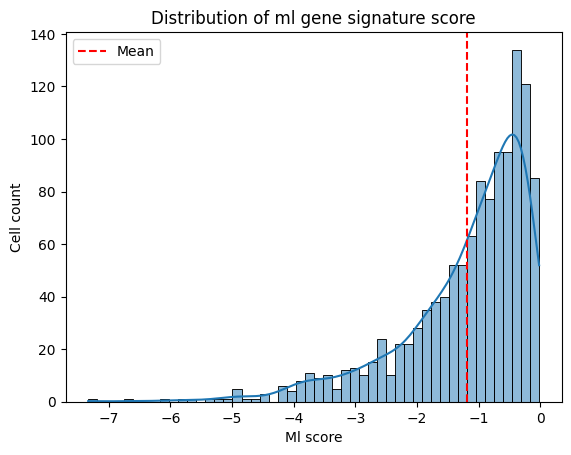

In [7]:
adata = gse.objects[filenames[0]]
subset_genes = True

for gene_signature, filename in gene_signature_filenames.items():
    signature_df = pd.read_excel(get_resources_path(gse.STUDY_ID + '/' + filename))
    genes = signature_df.loc[:, 'Symbol'].dropna().unique().tolist()
    if subset_genes:
        # only return the genes that exist in target dataset
        genes = [gene for gene in genes if gene in adata.var_names]
    sc.tl.score_genes(adata, gene_list=genes, score_name=f'score_{gene_signature}')
    kde_gene_signature_score(adata, gene_signature)


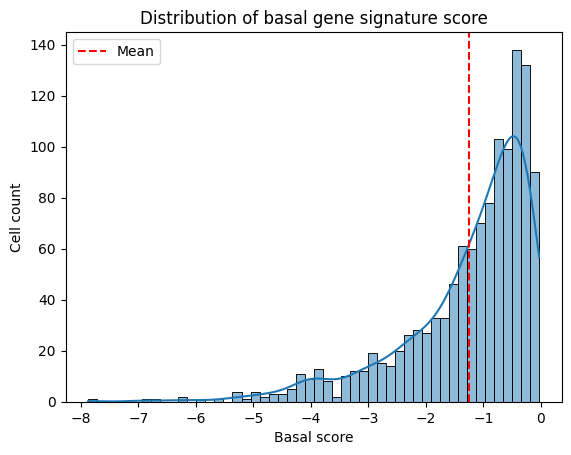

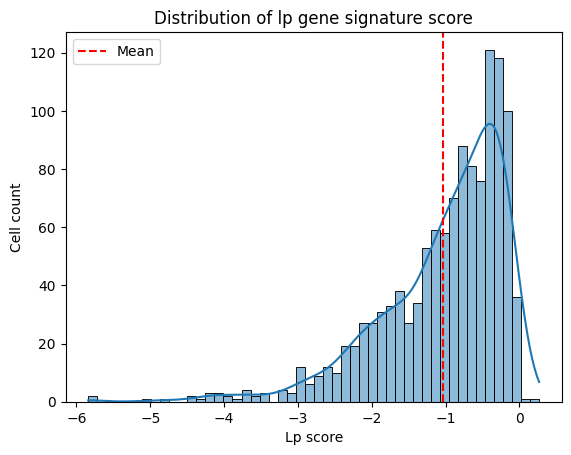

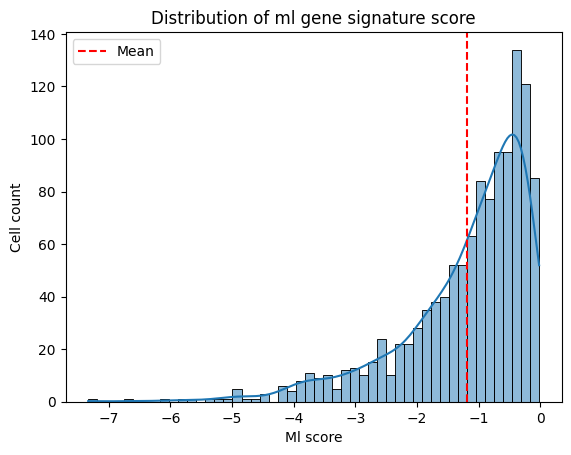

In [8]:
adata = gse.objects[filenames[0]]
subset_genes = True

adata_cached = adata.copy()
for gene_signature, filename in gene_signature_filenames.items():
    signature_df = pd.read_excel(get_resources_path(gse.STUDY_ID + '/' + filename))
    genes = signature_df.loc[:, 'Symbol'].dropna().unique().tolist()
    if subset_genes:
        # only return the genes that exist in target dataset
        genes = [gene for gene in genes if gene in adata_cached.var_names]
    # sc.pp.normalize_total(adata_cached)
    # sc.pp.log1p(adata_cached)
    # sc.pp.highly_variable_genes(adata)
    # adata = adata[:, adata.var['highly_variable']]
    sc.tl.score_genes(adata_cached, gene_list=genes, score_name=f'score_{gene_signature}')
    kde_gene_signature_score(adata_cached, gene_signature)
    adata_cached = adata.copy()

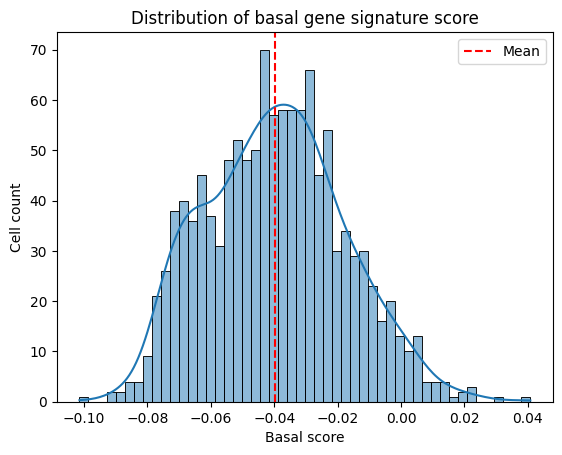

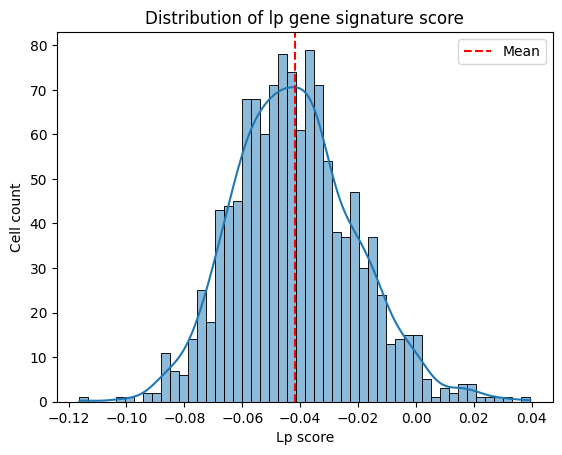

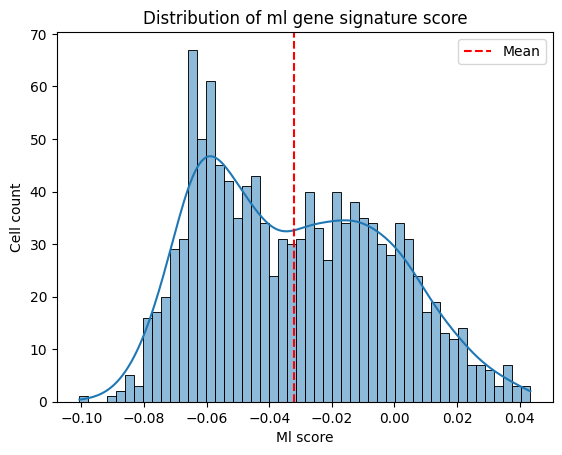

In [9]:
subset_genes = True

adata_cached = adata.copy()
for gene_signature, filename in gene_signature_filenames.items():
    signature_df = pd.read_excel(get_resources_path(gse.STUDY_ID + '/' + filename))
    genes = signature_df.loc[:, 'Symbol'].dropna().unique().tolist()
    if subset_genes:
        # only return the genes that exist in target dataset
        genes = [gene for gene in genes if gene in adata.var_names]
    sc.pp.normalize_total(adata)
    sc.pp.log1p(adata)
    # sc.pp.highly_variable_genes(adata)
    # adata = adata[:, adata.var['highly_variable']]
    sc.tl.score_genes(adata, gene_list=genes, score_name=f'score_{gene_signature}')
    kde_gene_signature_score(adata, gene_signature)
    adata = adata_cached.copy()

C:\Users\silly\GitHub\signals-in-the-noise\.venv\Lib\site-packages\scanpy\tools\_utils.py:40: UserWarning: You’re trying to run this on 33538 dimensions of `.X`, if you really want this, set `use_rep='X'`.
         Falling back to preprocessing with `sc.pp.pca` and default params.
  warnings.warn(


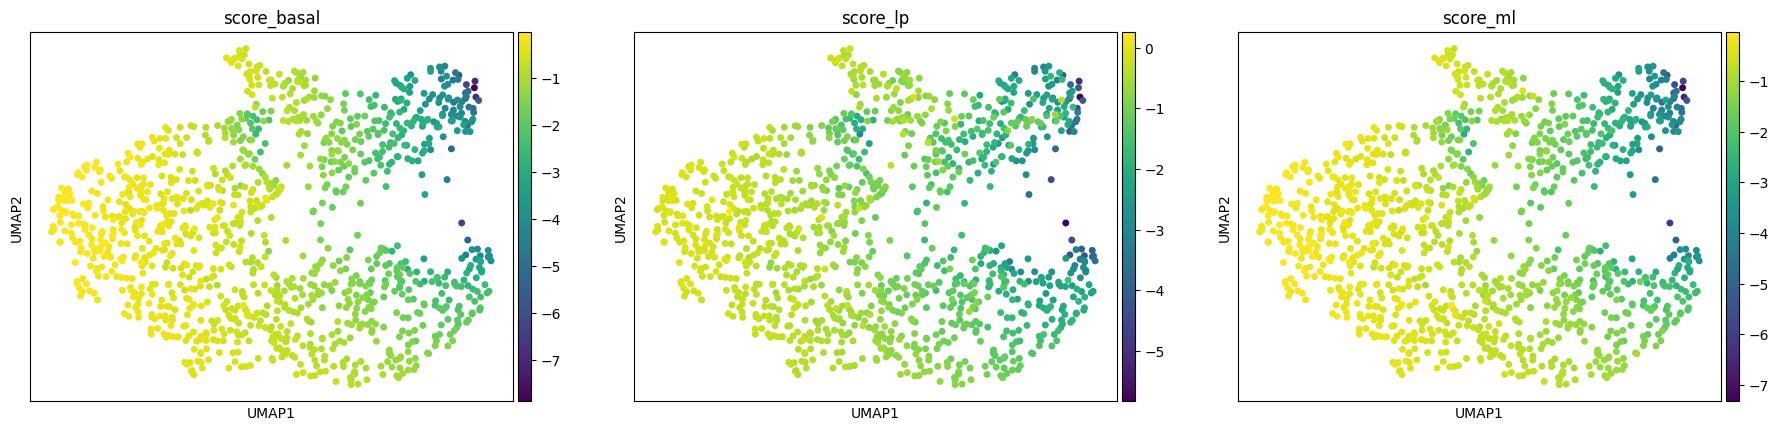

In [10]:
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.pl.umap(adata, color=['score_basal', 'score_lp', 'score_ml'])